# Churn Analysis

## 1. Introduction

Description of the data set
This is a toy example of a non-subscription marketplace. The events set contains the web logs from the seller, product, buy pages. The products set describes the items for sale.


Import the libraries

In [1]:
# Import the libraries
import pandas as pd
from datetime import datetime 
from sklearn.externals.six import StringIO  
from sklearn.linear_model import LogisticRegression
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from scipy import stats
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn import tree
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pylab as plt
%matplotlib inline
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns # advanced vizs
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 9
pd.options.display.float_format = '{:.2f}'.format


Import the data from csv files and store it in pandas dataframes. 

In [2]:
data1=pd.read_csv('products1.csv')
data2=pd.read_csv('events1.csv')

Sample data looks as below.

In [3]:
data1.head(),data2.head()

(   PRODUCT_ID  PRICE  CATEGORY_0  CATEGORY_1
 0           0  20.04           9          38
 1           1   7.02           5          37
 2           2  10.00           6          19
 3           3  12.00           4          12
 4           4   0.01           1          39,
           TIMESTAMP  USER_ID      TYPE  PRODUCT_ID  OVERVIEW_ID
 0  07/10/2014 12:00        7   product     5209.00       217460
 1  07/10/2014 12:00        7  overview         nan       140700
 2  07/10/2014 12:00        7   product   800435.00       276485
 3  07/10/2014 20:00        7  overview         nan        89705
 4  07/10/2014 20:00        7   product   250836.00       105130)

By observing the data below assumptions were made.
1. Product data has CATEGORY_0 and CATEGORY_1 - Here CATEGORY_0 is considered as Main category and CATEGORY_1 is considered as a subcategory.
2. Event data has Timestamp for each activity.
3. TYPE column has different activities.
    1. overview - Users activity of viewing the items in the categories. Each users overview is given an OVERVIEW_ID. Here the customer is viewing many items in the category hence Overview type is not given a product_ID.
    2. product - Users activity of viewing a particular product. Each product is identified by a PRODUCT_ID and an OVERVIEW_ID.
    3. purchase - Users activity of viewing a particular product. Each product is identified by a PRODUCT_ID and an OVERVIEW_ID. Whenever a user views a product and purchases them, the overview_id for both the activities will be same.
    

Join product and event data on **PRODUCT_ID** to form a newdataset.

In [4]:
result = pd.merge(data1, data2, on='PRODUCT_ID', how='right')

Sample data looks as below

In [5]:
result.dropna(inplace=True)

In [6]:
result.head()

,PRODUCT_ID,PRICE,CATEGORY_0,CATEGORY_1,TIMESTAMP,USER_ID,TYPE,OVERVIEW_ID
0,0.00,20.04,9.00,38.00,07/12/2014 20:00,1015504,product,455490
1,2.00,10.00,6.00,19.00,07/12/2014 18:00,262836,product,3890
2,6.00,39.18,1.00,45.00,13/12/2014 14:00,211435,product,2750
4,8.00,29.49,2.00,105.00,28/01/2015 21:00,122290,product,29470
5,8.00,29.49,2.00,105.00,24/11/2014 18:00,157339,product,29470


Here chrun is defined as: users viewing the products multiple times but not going further to purchase them.  Since we will be calling purchasing is a succesful transaction, we will be considering the TYPES product and purchase only by discarding the overview.

##  2. Data Preparation and Feature Selection

Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

These following features currently exist in our dataset **result**.
1. PRODUCT_ID: Unique identifier to each product
2. PRICE: Price for the product
3. CATEGORY_0: Main category the product belongs to.
4. CATEGORY_1: Sub category to CATEGORY_0
5. TIMESTAMP: Timestamp of the activity or transaction.
6. USER_ID: Unique identifier to User.
7. TYPE: Type of the activity.
8. OVERVIEW_ID: User session id.

From the existing features its hard to analyse the data further.
In order to predict the future purchases its important to extract key features from the existing variables.



### 2.1. Data Preparation
From the timestamp variable following features have been extracted.
1. Day_of_week: Day of the week the activity has been done.(Sun-Sat: 0-6)
2. Day_of_Month: 1-31
3. month_of_year: 1-12
4. Hour_of_day:00-23


In [7]:
# Convert timestamp column into timestamp type 
result['TIMESTAMP'] = result['TIMESTAMP'].apply(lambda x: datetime.strptime(x,'%d/%m/%Y %H:%M'))
# Extract the features from timestamo column 
result['Day_of_week']=result['TIMESTAMP'].dt.dayofweek
result['Day_of_Month']=result['TIMESTAMP'].dt.day
result['month_of_year']=result['TIMESTAMP'].dt.month
result['Hour_of_day']=result['TIMESTAMP'].dt.hour
result['Day']=result['TIMESTAMP'].dt.weekday_name

The result dataset looks as below

In [8]:
result.head()

,PRODUCT_ID,PRICE,CATEGORY_0,CATEGORY_1,TIMESTAMP,USER_ID,TYPE,OVERVIEW_ID,Day_of_week,Day_of_Month,month_of_year,Hour_of_day,Day
0,0.00,20.04,9.00,38.00,2014-12-07 20:00:00,1015504,product,455490,6,7,12,20,Sunday
1,2.00,10.00,6.00,19.00,2014-12-07 18:00:00,262836,product,3890,6,7,12,18,Sunday
2,6.00,39.18,1.00,45.00,2014-12-13 14:00:00,211435,product,2750,5,13,12,14,Saturday
4,8.00,29.49,2.00,105.00,2015-01-28 21:00:00,122290,product,29470,2,28,1,21,Wednesday
5,8.00,29.49,2.00,105.00,2014-11-24 18:00:00,157339,product,29470,0,24,11,18,Monday


##### Target Column
TYPE has 3 categories. When the activity is 'purchase', the product has been bought successfully and other activities are considered as unsuccessful transactions. A new target variable is created to indicate this

1. Buy - 0: unsuccessful transaction 1:successful transaction

In [9]:
# Add a column to indicate if an item is purchased or not
result['BUY']=np.where(result['TYPE']=='purchase',1,0)

In [10]:
# Sort the dataset based on Product_id and TIMESTAMP
result=result.sort_values(['PRODUCT_ID', 'TIMESTAMP'], ascending=[True, True])

### 2.2 Feature extraction

Below are the set of features extracted from the existing dataset
1. product_buy: Number of times the product has been purchased before this transaction(incremental).
2. User_buy: Number of purchases made by the user in the last 5 months
3. user_session: Number of users sessions in the last 5 months
4. user_buy_category: Number of items user bought the items in the last 5 months in the same category

Here for the variables User_buy, user_session, user_buy_category it is assumed that the user behaviour is same throughout. The entire dataset is used calculate these values.

In [11]:
# Number of purchases made by the user in the last 5 months
user_purchase=result[result['TYPE']=='purchase'].groupby(['USER_ID']).sum()['BUY']
user_purchase=pd.DataFrame(dict(User_buy = user_purchase)).reset_index()
result1=pd.merge(result,user_purchase,on='USER_ID',how='left')
result1['User_buy']=result1['User_buy'].fillna(0)

In [12]:
# Number of times this product is bought before 5 months
product_buy=result[result['TYPE']=='purchase'].groupby(['PRODUCT_ID']).sum()['BUY']
product_buy=pd.DataFrame(dict(product_buy = product_buy)).reset_index()
result2=pd.merge(result1,product_buy,on='PRODUCT_ID',how='left')

In [13]:
# Number of times this product has been bought before this transaction
result2=result2.sort_values(['PRODUCT_ID', 'TIMESTAMP'], ascending=[True, True])
x=result2['PRODUCT_ID'].tolist()
y=result2['BUY'].tolist()
count=0
z=[]
for i in range(0,len(x)):
    if x[i]==x[i-1] :
        if y[i]==1:
            z.append(count)
            count=count+1
        else:
            z.append(count)
  
    elif x[i]!=[i-1]:
        if y[i]==1:
            z.append(0)
            count=1
        else:
            count=0
            z.append(0)
result2['Bought_Before']=z        


In [14]:
# Number of users session in the last 5 months
user_session=result2.groupby(['USER_ID']).count()['BUY']
user_session=pd.DataFrame(dict(user_session = user_session)).reset_index()
result3=pd.merge(result2,user_session,on='USER_ID',how='left')

In [15]:
# Number of items user bought before in the last 5 months in the same category
user_buy_category=result3.groupby(['USER_ID','CATEGORY_0']).sum()['BUY']
user_buy_category=pd.DataFrame(dict(user_buy_category = user_buy_category)).reset_index()


result4=pd.merge(result3,user_buy_category,on=['USER_ID','CATEGORY_0'],how='left')

Our final dataset looks as below

In [16]:
result4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718992 entries, 0 to 718991
Data columns (total 19 columns):
PRODUCT_ID           718992 non-null float64
PRICE                718992 non-null float64
CATEGORY_0           718992 non-null float64
CATEGORY_1           718992 non-null float64
TIMESTAMP            718992 non-null datetime64[ns]
USER_ID              718992 non-null int64
TYPE                 718992 non-null object
OVERVIEW_ID          718992 non-null int64
Day_of_week          718992 non-null int64
Day_of_Month         718992 non-null int64
month_of_year        718992 non-null int64
Hour_of_day          718992 non-null int64
Day                  718992 non-null object
BUY                  718992 non-null int32
User_buy             718992 non-null float64
product_buy          107586 non-null float64
Bought_Before        718992 non-null int64
user_session         718992 non-null int64
user_buy_category    718992 non-null int32
dtypes: datetime64[ns](1), float64(6), int32(2), 

In [17]:
churn=result4[['PRODUCT_ID','USER_ID','PRICE','CATEGORY_0','CATEGORY_1','Day_of_week','month_of_year','Hour_of_day','Day_of_Month','User_buy','Bought_Before','user_session','user_buy_category','BUY']].copy()

In [18]:
churn.describe()

,PRODUCT_ID,USER_ID,PRICE,CATEGORY_0,CATEGORY_1,Day_of_week,month_of_year,Hour_of_day,Day_of_Month,User_buy,Bought_Before,user_session,user_buy_category,BUY
count,718992.00,718992.00,718992.00,718992.00,718992.00,718992.00,718992.00,718992.00,718992.00,718992.00,718992.00,718992.00,718992.00,718992.00
mean,417985.07,519994.20,6683.45,3.71,54.19,3.00,7.77,15.22,15.15,2.50,0.06,171.33,0.74,0.06
std,242100.98,308640.97,523054.53,3.21,33.41,2.00,4.76,5.29,8.67,7.04,0.31,399.55,2.84,0.23
min,0.00,7.00,0.01,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
25%,207380.25,242291.00,7.98,1.00,31.00,1.00,1.00,11.00,8.00,0.00,0.00,12.00,0.00,0.00
50%,418301.00,517874.00,15.07,2.00,43.00,3.00,10.00,16.00,15.00,1.00,0.00,39.00,0.00,0.00
75%,627170.50,789131.00,28.07,6.00,83.00,5.00,12.00,20.00,22.00,2.00,0.00,135.00,1.00,0.00
max,837867.00,1062964.00,57006748.96,11.00,124.00,6.00,12.00,23.00,31.00,105.00,10.00,3206.00,62.00,1.00


### 2.3. Correlation 



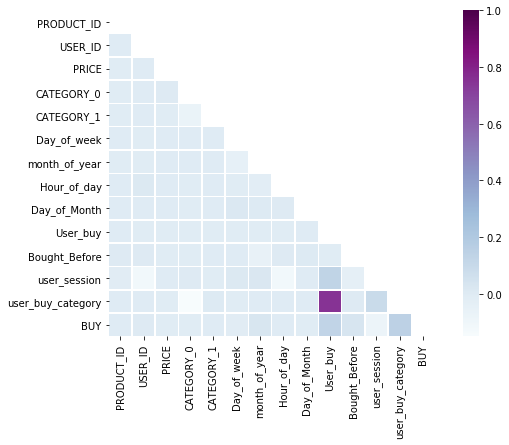

In [19]:

# Compute the correlation matrix 

corr_all = churn.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (10, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

from the correlation matrix it can be seen that the variables User_buy and User_buy_category are highly correlated. Since both the variables almost provide same information, one of the variables(User_buy) has been dropped from the dataframe.

In [20]:
churn=churn.drop(['User_buy'],axis=1)


## 3. Data Exploration


Below table shows average number of views on products before a product is purchased.

In [21]:
#Below table shows average number of views on products before a product is purchased.
print(55*'=')
a=data2['TYPE'].value_counts()['product']
b=data2['TYPE'].value_counts()['purchase']
c=data2['TYPE'].value_counts()['product']/result['TYPE'].value_counts()['purchase']
print('Total Number of Product views:',a, '\nTotal number of purchases made:',b,'\nRatio of product views to purchases:',round(c,2))
print(55*'=')

Total Number of Product views: 683214 
Total number of purchases made: 41453 
Ratio of product views to purchases: 16.61


### 3.2. Categorywise transaction analysis
Below plots show the products viewed and the products purchased in each categories respectively. Each category is named from the integer 0 to integer 11.

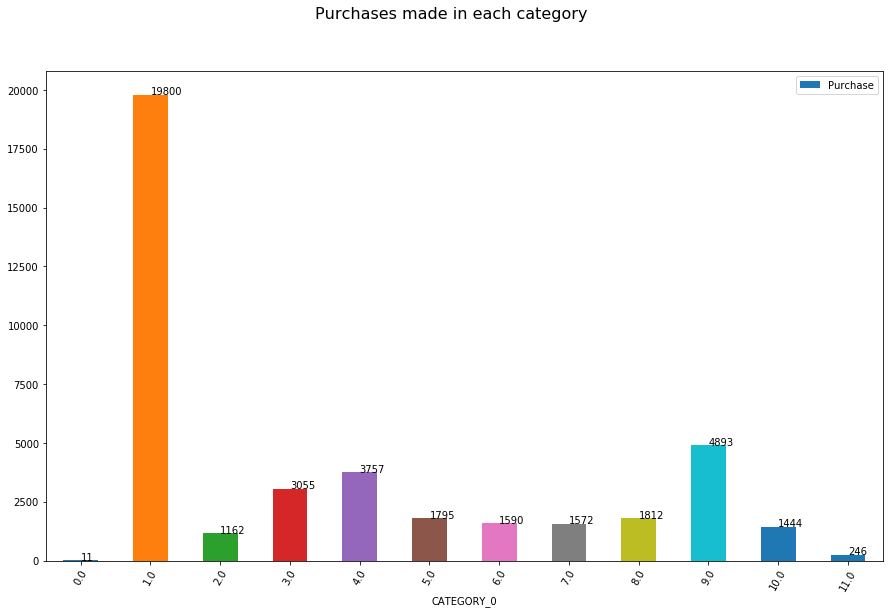

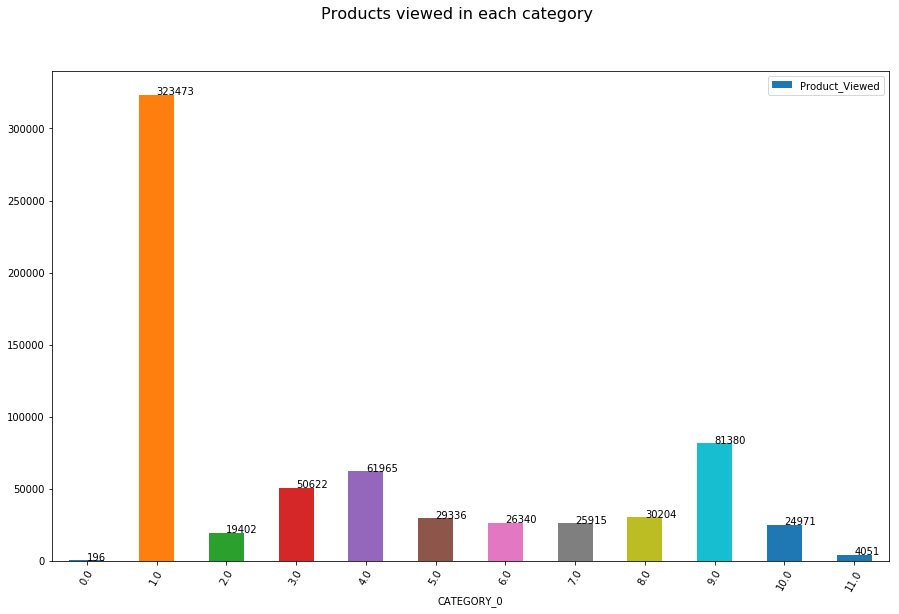

In [22]:
p1=result[result['TYPE']=='purchase']
p2=result[result['TYPE']=='PRODUCT']
p1=result[result['TYPE']=='purchase'].groupby(['CATEGORY_0']).count()['TYPE']
p2=result[result['TYPE']=='product'].groupby(['CATEGORY_0']).count()['TYPE']
p3=pd.DataFrame(dict(Purchase = p1, Product_Viewed = p2)).reset_index()
p3['Ratio']=p3['Product_Viewed']/p3['Purchase']

# Purchases made in each category
fig, ax = plt.subplots(figsize = (15, 9))
p3.plot.bar(x = 'CATEGORY_0', y = 'Purchase', rot = 60, ax = ax)
plt.suptitle('Purchases made in each category', fontsize=16)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))

#Products viewed in each category
fig, ax = plt.subplots(figsize = (15, 9))
p3.plot.bar(x = 'CATEGORY_0', y = 'Product_Viewed', rot = 60, ax = ax)
plt.suptitle('Products viewed in each category', fontsize=16)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))

From the above plot it can be observed that Category 1 has highest number of views and highest number of purchases

### 3.3. Purchases made at different times

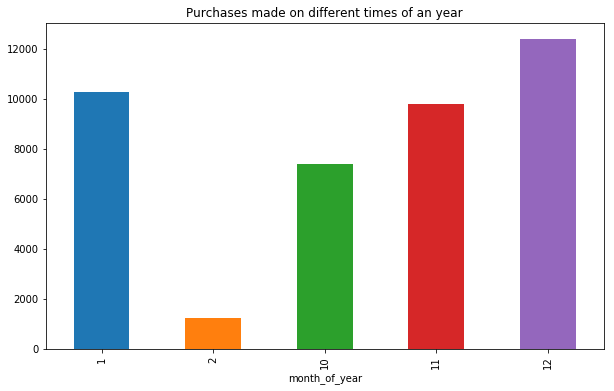

In [23]:
# Purchases made at different times, group by on month_of_year
fig, ax = plt.subplots(figsize=(10,6))
p4=result4[result4['BUY']==1].groupby(['month_of_year']).count()['BUY']
p4.plot(kind = 'bar', title = 'Purchases made on different times of an year')
plt.show()

From the above graph it can be seen that more products are sold during December-January. December-January are considered as holiday seasons.

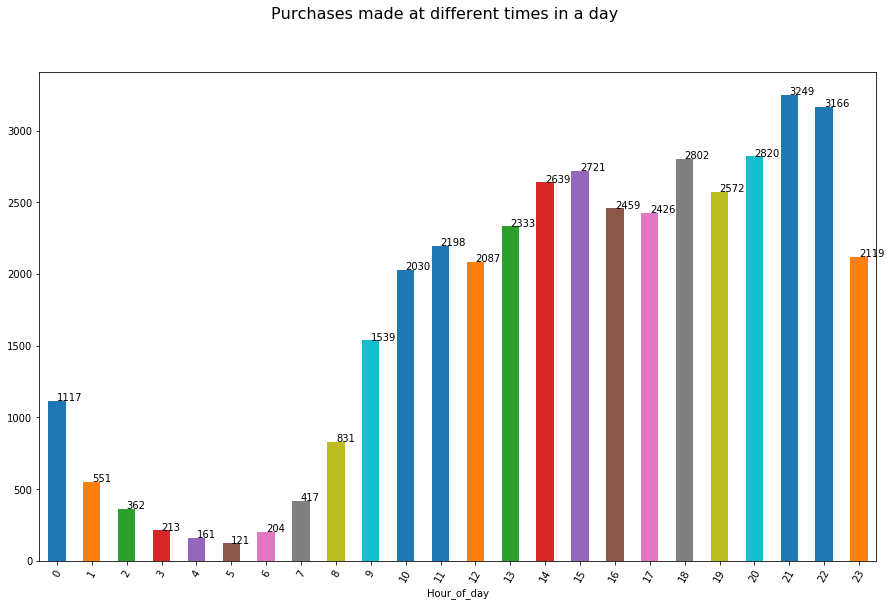

In [24]:
# Purchases made at different times in a day , group by on Hour_of_day
p5=result4[result4['BUY']==1].groupby(['Hour_of_day']).count()['BUY']
fig, ax = plt.subplots(figsize = (15, 9))
p5.plot.bar(x = 'Hour_of_day', y = 'BUY', rot = 60, ax = ax)
plt.suptitle('Purchases made at different times in a day', fontsize=16)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))


From the above graph it can be observed that most products are bought during the night time.

### 3.4. Average price of the items in each category.

In [25]:
# Average price of the items in each category.
temp=result4.drop_duplicates(subset=['CATEGORY_0','CATEGORY_1','PRICE','BUY'], keep='first', inplace=False)
p6=temp.groupby('CATEGORY_0').agg({'CATEGORY_1': 'count', 'PRICE': 'mean','BUY':'sum'})

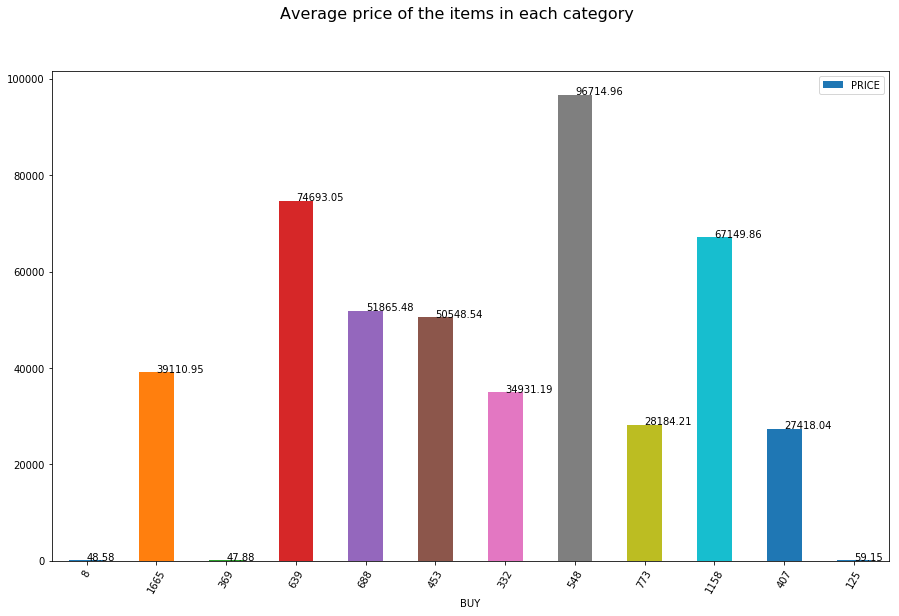

In [26]:
# Plot Average price of the items in each category.
fig, ax = plt.subplots(figsize = (15, 9))
p6.plot.bar(x = 'BUY', y = 'PRICE', rot = 60, ax = ax)
plt.suptitle('Average price of the items in each category', fontsize=16)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))


Above graph shows average price of iteams in each category.

## 4. Prediction Analysis

So far we tried to analyse the patterns in the data and extracted the features. 

Observing the data, we can find that the data is not balanced. That is, most of the data predominantly has the result of 'not buy'. This can highly influence the model since there more samples from one class than the other. To make the number of sample from both classes, random over-sampling technique can be used. In this technique, the minority class i.e. the 'buy' class is over-sampled by picking at random with replacement. This method evens out the number of samples from both classes in the dataset. 
  


By oversampling only on the training data, none of the information in the validation data is being used to create synthetic observations. So these results should be generalizable. 

In [27]:
# Split the data

X=churn[['PRODUCT_ID','USER_ID','PRICE','CATEGORY_0','CATEGORY_1','Day_of_week','month_of_year','Hour_of_day','Day_of_Month','Bought_Before','user_session','user_buy_category']].copy()
Y=churn['BUY']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

#sm = SMOTE(random_state=12, ratio = 1.0)
#X_resampled, y_resampled = sm.fit_sample(X_train, y_train)
# user oversampler library to balance the data.

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

After preparing the final dataset, variable **BUY** is predicted using following variables.

* PRODUCT_ID: Unique identifier to each product
* PRICE: Price for the product
* CATEGORY_0: Main category the product belongs to.
* CATEGORY_1: Sub category to CATEGORY_0
* USER_ID: Unique identifier to User.
* Day_of_week: Day of the week the activity has been done.(Sun-Sat: 0-6)
* Day_of_Month: 1-31
* month_of_year: 1-12
* Hour_of_day:00-23
* product_buy: Number of times the product has been purchased before this transaction(incremental).
* user_session: Number of users sessions in the last 5 months
* user_buy_category: Number of items user bought the items in the last 5 months in the same category

### 4.1 Logistic Regression

Logistic regression algorithm is used to predict the successful transaction as below.

In [28]:
# Fit logistic model on train data and predict the test data 
logisticRegr = LogisticRegression()
logisticRegr.fit(X_resampled, y_resampled)
Y_pred = logisticRegr.predict(X_test)
print(accuracy_score(y_test,Y_pred),confusion_matrix(y_test,Y_pred))



0.8545948041876696 [[190239  33436]
 [  1064  12529]]


In [29]:
# Confusion matrix
cm = metrics.confusion_matrix(y_test,Y_pred)
score = logisticRegr.score(X_test, y_test)*100
print(score)


85.45948041876696


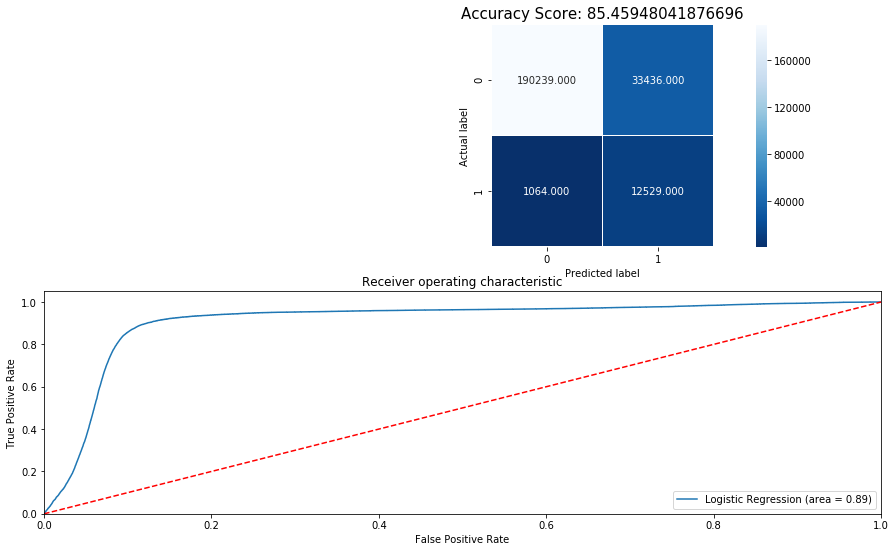

In [30]:
# Plot Confusion matrix heatmap
plt.figure(0,figsize=(15,9))
plt.subplot(211)
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

#Plot ROC map
logit_roc_auc = roc_auc_score(y_test, logisticRegr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logisticRegr.predict_proba(X_test)[:,1])
plt.subplot(212)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The above confusion matrix displays 
1. 190239 unsuccessful transactions were predicted properly while 33436 unsuccessful transactions were not predicted accurately.
2. 12529 succesful transactions were predicted accurately while other 1064 predictions were not succesful.

Here we can observe that propotion between 1 and 2 are similar. over-sampling technique helped us to improve the model by randomizing the minority class.
Logistic regression model produced an accuracy of 85.5%


### 4.2 Decision Tree

In decision analysis, a decision tree can be used to visually and explicitly represent decisions and decision making while predicitng.

In [31]:
# Function to model decision trees, display it and predict the test data. plot heatmap of confusion matrix and feature importance
def dec_tree(X_train,Y_train,X_test,Y_test,Models):
    decision_tree = DecisionTreeClassifier(min_samples_split=500)
    decision_tree.fit(X_train, Y_train)
    Y_pred = decision_tree.predict(X_test)
    Models['Decision Tree'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    print(confusion_matrix(Y_test, Y_pred))
    features=['PRODUCT_ID','USER_ID','PRICE','CATEGORY_0','CATEGORY_1','Day_of_week','month_of_year','Hour_of_day','Day_of_month','Bought_Before','user_session','user_buy_category']
    #show_tree(decision_tree)
    print(Models)
    score = decision_tree.score(X_test, y_test)*100
    plt.figure(0,figsize=(15,9))
    plt.subplot(211)
    cm = metrics.confusion_matrix(Y_test,Y_pred)
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
    importances = decision_tree.feature_importances_
    indices = np.argsort(importances)
    plt.figure(0)
    plt.subplot(212)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features)
    plt.xlabel('Relative Importance')
    return decision_tree

# To display the decision tree
def show_tree(tree):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data, 
                filled=True, rounded=True,
                special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    Image(graph.create_png())

[[201193  22482]
 [  1814  11779]]
{'Decision Tree': [0.8976010250012644, array([[201193,  22482],
       [  1814,  11779]], dtype=int64)]}


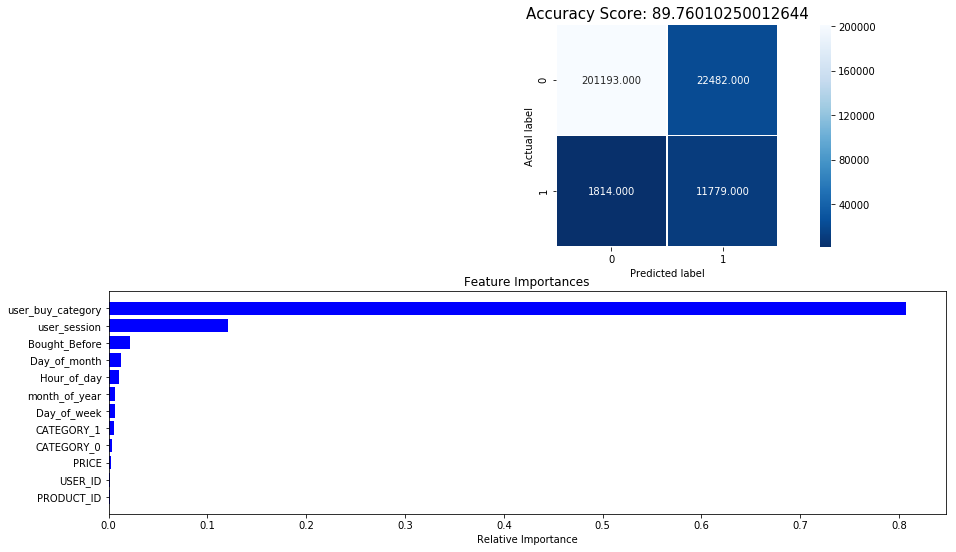

In [32]:
# Call the decision tree function
Models=dict()
features=['PRODUCT_ID','USER_ID','PRICE','CATEGORY_0','CATEGORY_1','Day_of_week','month_of_year','Hour_of_day','Day_of_Month','Bought_Before','user_session','user_buy_category']
decision_tree=dec_tree(X_resampled,y_resampled,X_test,y_test,Models)
#for name, importance in zip(features, decision_tree.feature_importances_):
 #       print(name, importance)

From the above graph, decision tree model was able to predict 89% of the transactions correctly. and also from the feature importance graph, we could observe that decision tree model considered user behaviours as their important variables to split. This result helps in identifying key features to increase the purchases.

### 4.3 Statistical Analysis
From the decision tree model we found out that the variables user_session, user_buy_category, Bought_before variables play important role in deciding the model predictors. To analyze this model further, lets take a mean of all the variables and conduct t-test to find out the significance. 

In [33]:
# Mean of the variables in both the groups
churn.groupby('BUY').mean()

,PRODUCT_ID,USER_ID,PRICE,CATEGORY_0,CATEGORY_1,Day_of_week,month_of_year,Hour_of_day,Day_of_Month,Bought_Before,user_session,user_buy_category
BUY,,,,,,,,,,,,
0,417962.13,519453.87,6930.92,3.71,54.20,3.00,7.74,15.22,15.17,0.06,179.08,0.63
1,418363.11,528897.74,2605.49,3.68,54.03,2.95,8.35,15.27,14.95,0.11,43.67,2.48


From the above table we can see that the variables PRICE, Bought_Before, user_session, user_buy_category variables have significant difference between both the groups .
Lets apply t test on these variables and find out.

In [34]:
print('PRICE             :-',stats.ttest_ind(churn[churn['BUY']==1].PRICE,churn[churn['BUY']==0].PRICE))
print('user_session      :-',stats.ttest_ind(churn[churn['BUY']==1].user_session,churn[churn['BUY']==0].user_session))
print('user_buy_category :-',stats.ttest_ind(churn[churn['BUY']==1].user_buy_category,churn[churn['BUY']==0].user_buy_category))
print('Bought_Before     :-',stats.ttest_ind(churn[churn['BUY']==1].Bought_Before,churn[churn['BUY']==0].Bought_Before))
print('CATEGORY_0        :-',stats.ttest_ind(churn[churn['BUY']==1].CATEGORY_0,churn[churn['BUY']==0].CATEGORY_0))
print('CATEGORY_1        :-',stats.ttest_ind(churn[churn['BUY']==1].CATEGORY_1,churn[churn['BUY']==0].CATEGORY_1))

PRICE             :- Ttest_indResult(statistic=-1.6285689625804638, pvalue=0.10340473729419704)
user_session      :- Ttest_indResult(statistic=-66.95018110987134, pvalue=0.0)
user_buy_category :- Ttest_indResult(statistic=129.39543524519797, pvalue=0.0)
Bought_Before     :- Ttest_indResult(statistic=30.115458564696088, pvalue=4.0490298463343715e-199)
CATEGORY_0        :- Ttest_indResult(statistic=-1.7933335944776092, pvalue=0.07292001887131085)
CATEGORY_1        :- Ttest_indResult(statistic=-0.9925502874925252, pvalue=0.320929495373983)


From the t-test results we can conclude that user behaviour plays important role in the predicting the product purchase and also number of times the product has been purchased before plays vital role.

## 5. Results and Recommendations.

From the previous tests we concluded that user behaviour and product purchase history are important in decision making.

### 5.1 Recommendation 1
Identify the products which is never bought before and find a solution to market the product or to find the suitable customers for these products.
e.g. Identify the products which were never purchased before and provide discounts on those items. 

In [35]:
rec1=churn.groupby('PRODUCT_ID').agg({'BUY':'sum','PRICE':'mean'})
#rec1[rec1==0].head()
rec1[rec1['BUY']==0].head()



,BUY,PRICE
PRODUCT_ID,,
0.00,0,20.04
2.00,0,10.00
6.00,0,39.18
8.00,0,29.49
9.00,0,25.02


The above PRODUCT_IDs are the sample 5 products which are never sold before. These products could be overviewed for the discount. 

### 5.2 Recommendation 2
 Identify the customers who have viewed the products multiple times but never have made a purchase.Identify the reason he didnt make the purchase. Those customers can be encouraged by personal discounts as such.

In [36]:
rec2=churn.groupby('USER_ID').agg({'BUY':'sum','PRODUCT_ID':'count'})
#rec1[rec1==0].head()
rec2=rec2[rec2['BUY']==0]
rec2[rec2['PRODUCT_ID']>10].head()

,BUY,PRODUCT_ID
USER_ID,,
42,0,47
49,0,26
357,0,12
889,0,13
1008,0,13


Above are the sample set of users who viewed a product multiple times but never purchased.